## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

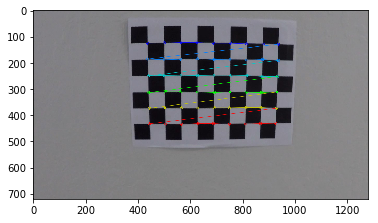

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
plt.imshow(img)

In [3]:
def calibrate_camera(images_dir, nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob(images_dir)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    
    return ret, mtx, dist

ret, mtx, dist = calibrate_camera('camera_cal/calibration*.jpg', 9, 6)

## Apply a distortion correction to raw images

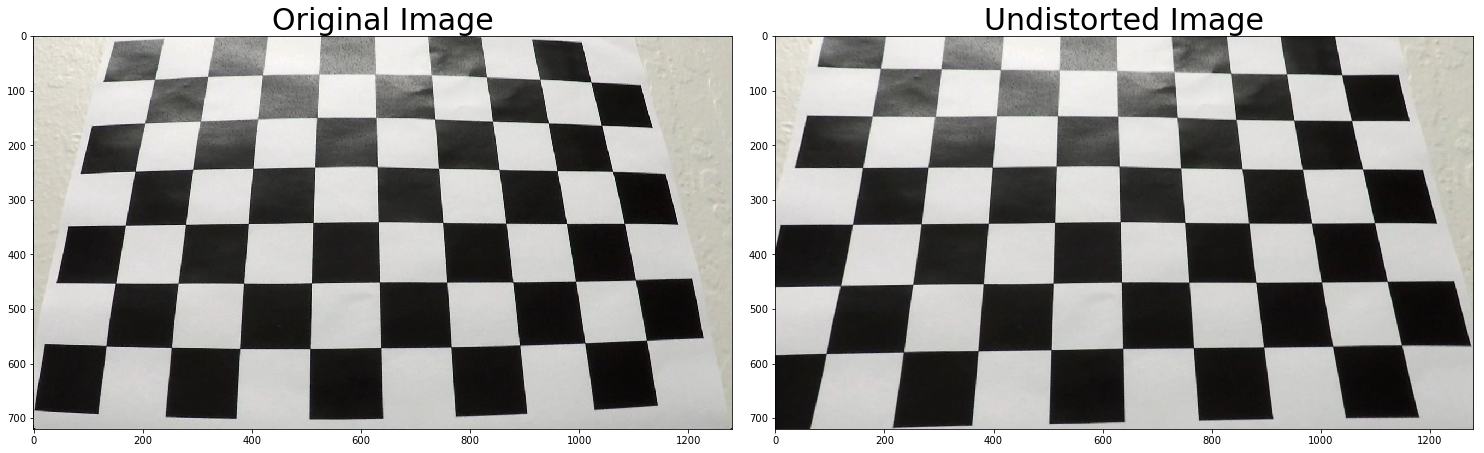

In [4]:
# Read in an image
img = mpimg.imread('camera_cal/calibration3.jpg')

# Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, mtx, dist):
    # Use cv2.undistort()
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

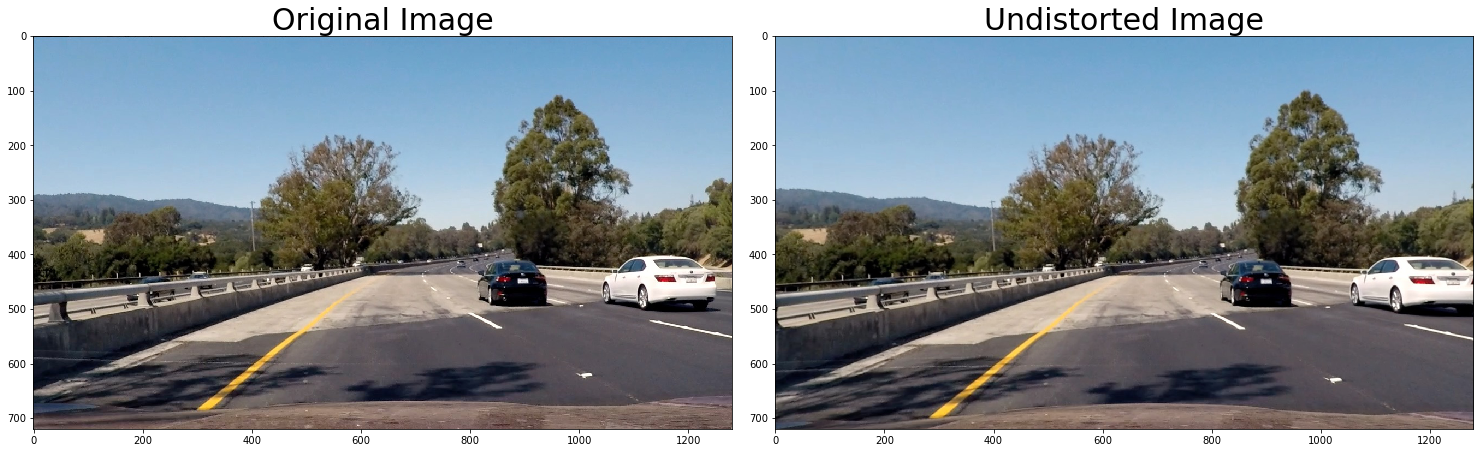

In [5]:
# Read in an image
img = mpimg.imread('test_images/test4.jpg')

undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Create a thresholded binary image

In [6]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, sobel_kernel=3, orient='x', abs_thresh=(0,255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, _mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= _mag_thresh[0]) & (gradmag <= _mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_select(img, s_thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    return binary_output


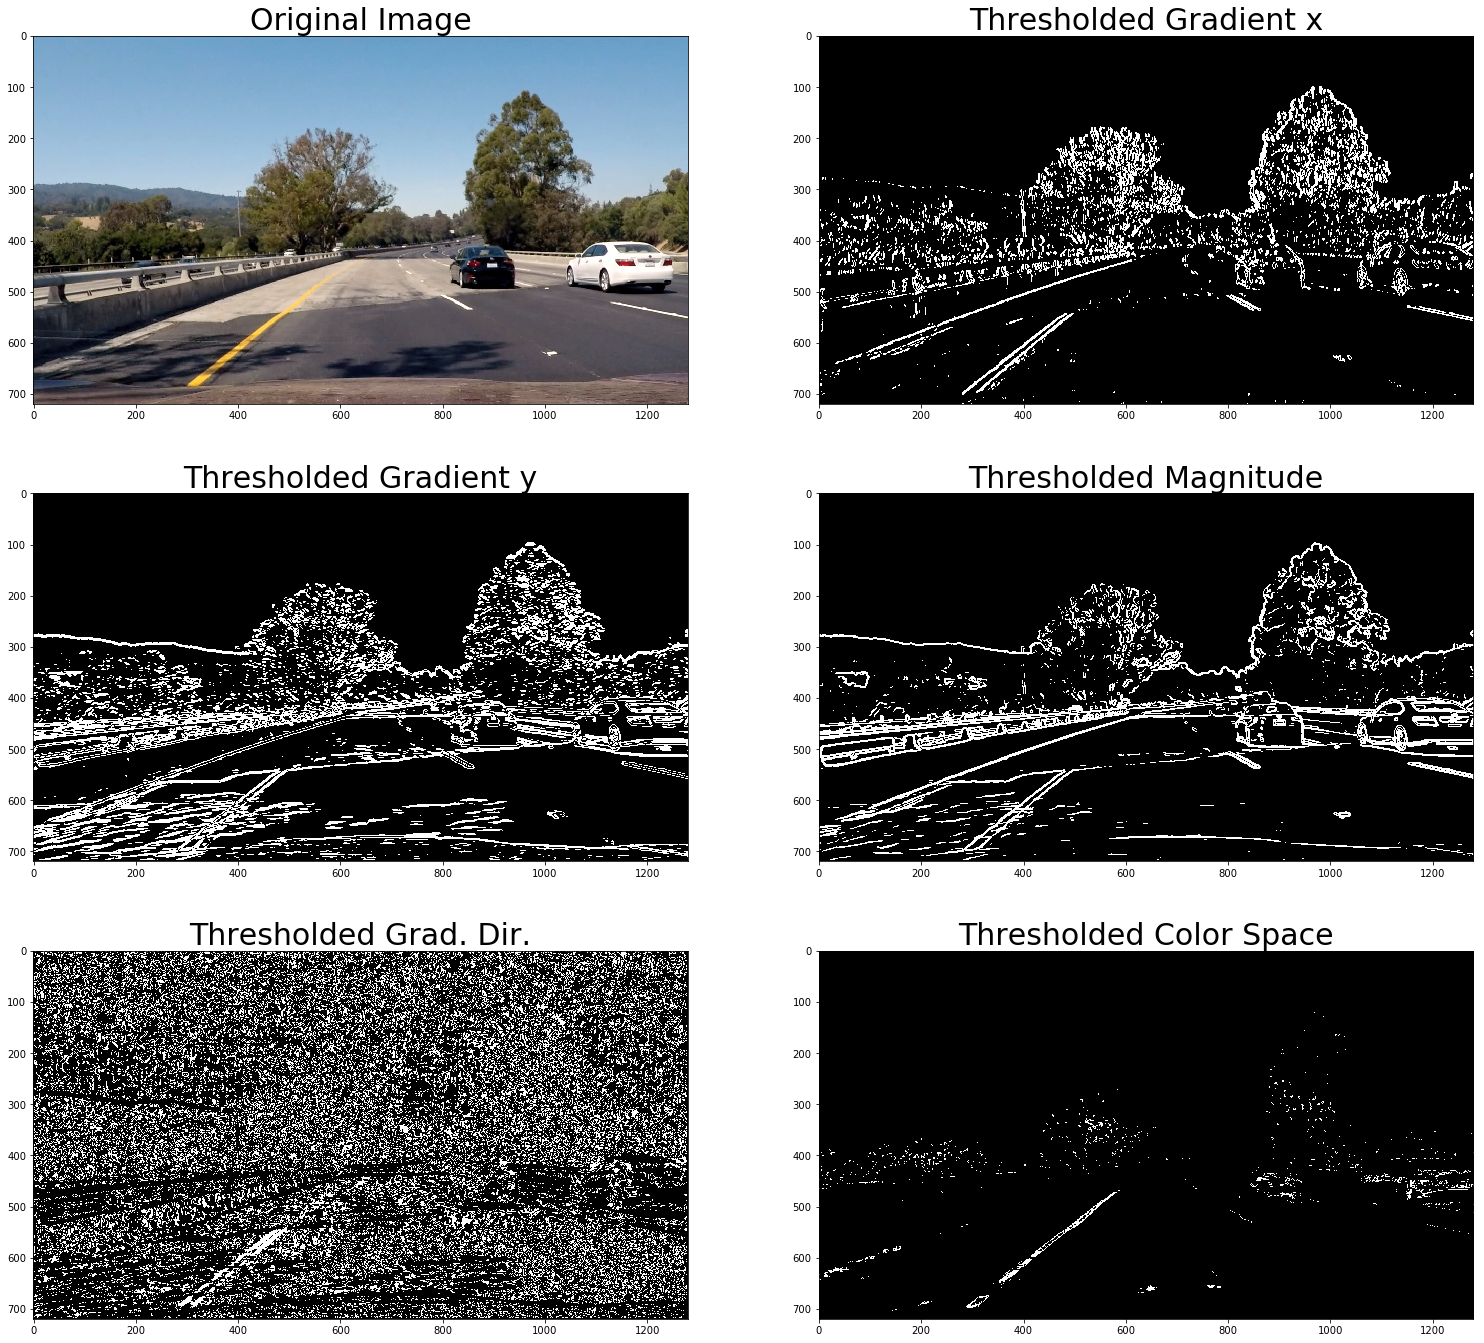

In [7]:
# Run the function
gradx_binary = abs_sobel_thresh(undistorted, sobel_kernel=9, orient='x', abs_thresh=(20,100))
grady_binary = abs_sobel_thresh(undistorted, sobel_kernel=9, orient='y', abs_thresh=(20,100))
mag_binary = mag_thresh(undistorted, sobel_kernel=9, _mag_thresh=(40, 200))
dir_binary = dir_threshold(undistorted, sobel_kernel=11, dir_thresh=(0.6, 1.1))
hls_binary = hls_select(undistorted, s_thresh=(175, 250))
# Plot the result
f, axes = plt.subplots(3, 2, figsize=(20, 20))
# f.tight_layout()
axes[0,0].imshow(img)
axes[0,0].set_title('Original Image', fontsize=30)
axes[0,1].imshow(gradx_binary, cmap='gray')
axes[0,1].set_title('Thresholded Gradient x', fontsize=30)
axes[1,0].imshow(grady_binary, cmap='gray')
axes[1,0].set_title('Thresholded Gradient y', fontsize=30)
axes[1,1].imshow(mag_binary, cmap='gray')
axes[1,1].set_title('Thresholded Magnitude', fontsize=30)
axes[2,0].imshow(dir_binary, cmap='gray')
axes[2,0].set_title('Thresholded Grad. Dir.', fontsize=30)
axes[2,1].imshow(hls_binary, cmap='gray')
axes[2,1].set_title('Thresholded Color Space', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [8]:
def combined_thresholding(img, kernel_size=9, s_thresh=(170, 255), abs_thresh=(20, 100), _mag_thresh=(40, 200), dir_thresh=(0.7,1.1)):
    img = np.copy(img)
    gradx_binary = abs_sobel_thresh(img, sobel_kernel=kernel_size, orient='x', abs_thresh=abs_thresh)
    grady_binary = abs_sobel_thresh(img, sobel_kernel=kernel_size, orient='y', abs_thresh=abs_thresh)
    mag_binary = mag_thresh(img, sobel_kernel=kernel_size, _mag_thresh=_mag_thresh)
    dir_binary = dir_threshold(img, sobel_kernel=kernel_size, dir_thresh=dir_thresh)
    hls_binary = hls_select(img, s_thresh=s_thresh)
    
    combined = np.zeros_like(dir_binary)
    combined[(((gradx_binary == 1) & (grady_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1)))| hls_binary ==1] = 1
    combined = combined.astype(np.uint8)
    return combined

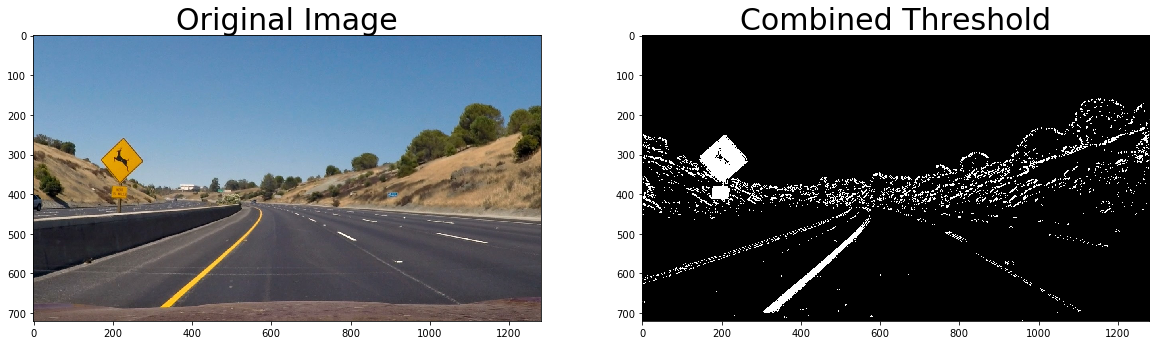

In [41]:
img = mpimg.imread('test_images/test2.jpg')

undistorted = cal_undistort(img, mtx, dist)
combined = combined_thresholding(undistorted, kernel_size=7)

f, axes = plt.subplots(1, 2, figsize=(20, 12))
# f.tight_layout()
axes[0].imshow(img)
axes[0].set_title('Original Image', fontsize=30)
axes[1].imshow(combined, cmap='gray')
axes[1].set_title('Combined Threshold', fontsize=30)

## Perspective transform

In [42]:
img.shape

(720, 1280, 3)

In [45]:
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def perspective_transform(img):
    # define 4 source points for perspective transformation
    src = np.float32([[200,720],[1200,720],[750,470],[580,470]])
    # define 4 destination points for perspective transformation
    dst = np.float32([[200,720],[1020,720],[1020,0],[200,0]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    # Return the resulting image
    return warped, M, Minv

binary_warped, M, Minv = perspective_transform(combined)

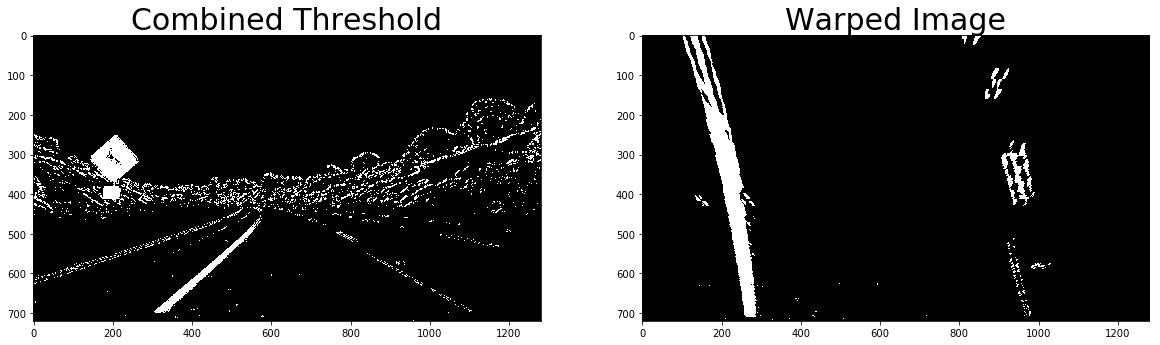

In [46]:
f, axes = plt.subplots(1, 2, figsize=(20, 12))
# f.tight_layout()
axes[0].imshow(combined, cmap='gray')
axes[0].set_title('Combined Threshold', fontsize=30)
axes[1].imshow(binary_warped, cmap='gray')
axes[1].set_title('Warped Image', fontsize=30)

## Detect lane

### Peaks in a Histogram

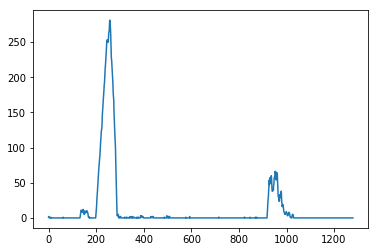

In [47]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

plt.plot(histogram)

### Sliding window search

In [48]:
def slide_window_search(binary_warped, nwindows):
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = nwindows
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        [0,0,255], 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        [0,0,255], 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    return left_lane_inds, right_lane_inds, out_img


left_lane_inds, right_lane_inds, out_img = slide_window_search(binary_warped, 9)

In [49]:
def fit_curve(binary_warped, left_lane_inds, right_lane_inds):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, ploty, left_fitx, right_fitx

left_fit, right_fit, ploty, left_fitx, right_fitx = fit_curve(binary_warped, left_lane_inds, right_lane_inds)

(720, 0)

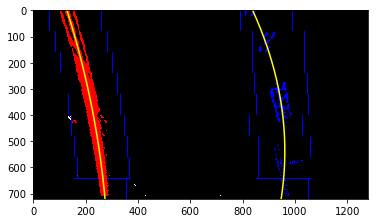

In [51]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [52]:
def continuous_search(binary_warped, left_fit, right_fit):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    return left_lane_inds, right_lane_inds


(720, 0)

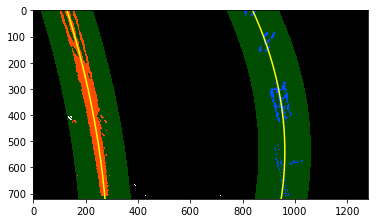

In [54]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Determine curvature

In [55]:
def cal_curvature(ploty, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(ploty*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

In [56]:
def center_offset(img_size, left_fitx, right_fitx):
    lane_center = (left_fitx[-1] + right_fitx[-1])/2
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_offset = abs(img_size[1]/2 - lane_center) * xm_per_pix
    
    return center_offset

## Draw polygon

In [164]:
def draw_poly(undist, warped, left_lane, right_lane, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_lane.bestx, left_lane.ally]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_lane.bestx, right_lane.ally])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    curvature_string = "Radius of curvature: %.2f m" % np.mean([left_lane.radius_of_curvature, right_lane.radius_of_curvature])
    offset_string = "Center offset: %.2f m" % left_lane.line_base_pos
    
    cv2.putText(result,curvature_string , (100, 90), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,255), thickness=2)
    
    return result

## Finalise pipeline

In [165]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def set_values(self, detected=False, current_fit=[np.array([False])], radius_of_curvature=None, line_base_pos=None, allx=None, ally=None):
        self.detected = detected 
        self.current_fit = current_fit 
        self.radius_of_curvature = radius_of_curvature
        self.line_base_pos = line_base_pos 
        self.allx = allx 
        self.ally = ally

In [186]:
def sanity_check(left_lane, right_lane):
    # Checking that they have similar curvature
    similar_cur = left_lane.radius_of_curvature/right_lane.radius_of_curvature
    # Checking that they are separated by approximately the right distance horizontally
    diffx_min = np.min(abs(left_lane.allx - right_lane.allx))
    diffx_max = np.max(abs(left_lane.allx - right_lane.allx))
    # Checking that they are roughly parallel
#     print(left_lane.radius_of_curvature, right_lane.radius_of_curvature)
#     print(diffx_min, diffx_max)
    if similar_cur > 0.25 and similar_cur < 4 and diffx_min > 500 and (diffx_max - diffx_min) < 100:
        return True
    else:
        return False

In [189]:
def process_image(image):
    global mtx, dist, prev_left_lane, prev_right_lane, no_detect_flag
    img_size = image.shape
    if mtx is None or dist is None:
         ret, mtx, dist = calibrate_camera("camera_cal/calibration*.jpg", 9, 6)
    undist = cal_undistort(image, mtx, dist)
    combined = combined_thresholding(undist)
    binary_warped, M, Minv = perspective_transform(combined)
    left_lane = prev_left_lane
    right_lane = prev_right_lane
    # Find the lines fitting to left and right lanes
    if no_detect_flag < 3:
#     if prev_left_lane.detected and prev_right_lane.detected:
        left_lane_inds, right_lane_inds = continuous_search(binary_warped, prev_left_lane.current_fit, prev_right_lane.current_fit)  
    else:
        left_lane_inds, right_lane_inds, _ = slide_window_search(binary_warped, nwindows=7)
        
    left_fit, right_fit, ploty, left_fitx, right_fitx = fit_curve(binary_warped, left_lane_inds, right_lane_inds)
    center_pos = center_offset(img_size, left_fitx, right_fitx)

    left_curverad = cal_curvature(ploty, left_fitx)
    left_lane.set_values(detected=True, current_fit=left_fit, radius_of_curvature=left_curverad, 
                         line_base_pos=center_pos, allx=left_fitx, ally=ploty)
    left_lane.recent_xfitted.append(left_lane.allx)
    if len(left_lane.recent_xfitted)>3:
        left_lane.recent_xfitted.pop(0)
    left_lane.bestx = np.mean(left_lane.recent_xfitted, axis=0)
        
    right_curverad = cal_curvature(ploty, right_fitx)
    right_lane.set_values(detected=True, current_fit=right_fit, radius_of_curvature=right_curverad, 
                          line_base_pos=center_pos, allx=right_fitx, ally=ploty)
    right_lane.recent_xfitted.append(right_lane.allx)
    if len(right_lane.recent_xfitted)>3:
        right_lane.recent_xfitted.pop(0)
    right_lane.bestx = np.mean(right_lane.recent_xfitted, axis=0)
        
    pass_sanity_check = sanity_check(left_lane, right_lane)
    if (not pass_sanity_check):
        left_lane = prev_left_lane
        right_lane = prev_right_lane
        prev_left_lane.detected = False
        prev_right_lane.detected = False
        no_detect_flag = no_detect_flag + 1
    else:
        no_detect_flag = 0
        
    result = draw_poly(undist, binary_warped, left_lane, right_lane, Minv)
    
    prev_left_lane = left_lane
    prev_right_lane = right_lane
    
    # Return the original image with colored region
    return result

In [173]:
test_img = mpimg.imread('test_images/test1.jpg')

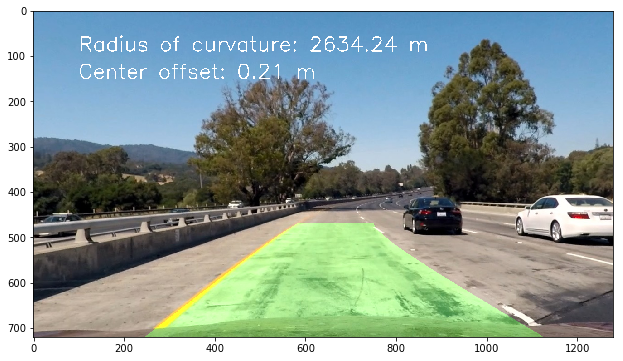

In [174]:
# set no_detect_flag to 3 before the processing starts, to trigger the slide window searching from scratch.

no_detect_flag = 3
result = process_image(test_img)
plt.figure(figsize=(12,6))
plt.imshow(result)

In [195]:
import imageio
imageio.plugins.ffmpeg.download()

In [196]:
from moviepy.editor import VideoFileClip

In [197]:
mtx, dist = None, None

In [201]:
# set no_detect_flag to 3 before the processing starts, to trigger the slide window searching from scratch.
# prev_left_lane, prev_right_lane = Line(), Line()
no_detect_flag = 3

In [ ]:
white_output = 'project_video_solution_3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(5,10)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [181]:
white_output = 'challenge_video_solution.mp4'
clip1 = VideoFileClip("challenge_video.mp4")#.subclip(40,50)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video challenge_video_solution.mp4
[MoviePy] Writing video challenge_video_solution.mp4


100%|██████████| 485/485 [02:51<00:00,  2.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_solution.mp4 

CPU times: user 4min 39s, sys: 1.53 s, total: 4min 41s
Wall time: 2min 52s
